## Importing the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
df = pd.read_csv('loan_application_data.csv')

In [5]:
df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome
0,2021-01-01 00:00:00.000000000,655,6306291,417034,Employed,159749,2011-11-24 19:42:42.126610048,Denied
1,2021-01-02 02:16:56.216216216,652,7555169,5730135,Self-Employed,334035,2006-12-25 19:23:45.596053728,Approved
2,2021-01-03 04:33:52.432432432,490,9578220,1886511,Unemployed,159927,2006-05-06 00:34:43.639353248,Approved
3,2021-01-04 06:50:48.648648648,759,7697704,9468833,Unemployed,3438,2009-01-22 19:20:12.496574400,Denied
4,2021-01-05 09:07:44.864864864,800,9040140,655286,Self-Employed,110166,2005-10-19 11:13:37.867909024,Approved


In [7]:
df.shape

(1000, 8)

In [9]:
df.isna().sum()

ApplicationDate        0
CreditScore            0
AnnualIncome           0
LoanAmount             0
EmploymentStatus       0
OutstandingDebt        0
EmploymentStartDate    0
LoanOutcome            0
dtype: int64

# Feature Engineering

In [12]:
# Convert to datetime
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])

# Separate into date and time
df['Appdate'] = df['ApplicationDate'].dt.date
df['Apptime'] = df['ApplicationDate'].dt.time

In [14]:
# Convert to datetime
df['EmploymentStartDate'] = pd.to_datetime(df['EmploymentStartDate'])

# Separate into date and time
df['Empdate'] = df['EmploymentStartDate'].dt.date
df['Emptime'] = df['EmploymentStartDate'].dt.time

In [16]:
from datetime import datetime

# Convert columns to datetime
df['Appdate'] = pd.to_datetime(df['Appdate'])
df['Empdate'] = pd.to_datetime(df['Empdate'])

# Calculate month difference
df['months_count'] = (df['Appdate'].dt.year - df['Empdate'].dt.year) * 12 + \
                     (df['Appdate'].dt.month - df['Empdate'].dt.month)

In [18]:
from datetime import datetime

# Convert columns to datetime
df['Appdate'] = pd.to_datetime(df['Appdate'])
df['Empdate'] = pd.to_datetime(df['Empdate'])

# Calculate years difference
df['YearsExp'] = df['Appdate'].dt.year - df['Empdate'].dt.year

In [20]:
# DTI
df['Debt-to-income'] = df['OutstandingDebt'] / df['AnnualIncome']

In [22]:
# LTI
df['Loan-to-income'] = df['LoanAmount'] / df['AnnualIncome']

<Axes: ylabel='count'>

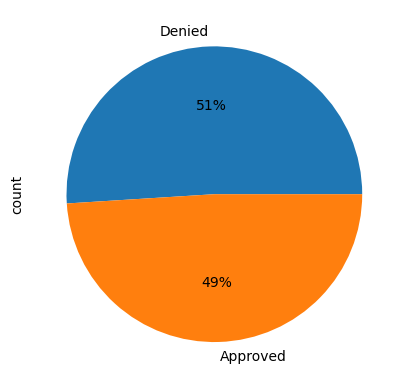

In [24]:
df['LoanOutcome'].value_counts().plot(kind = 'pie', autopct='%1.0f%%')

# Label Encoding

In [26]:
df1 = df.drop(['ApplicationDate','EmploymentStartDate','Appdate','Apptime','Empdate','Emptime','months_count'], axis=1)

In [28]:
df1['LoanOutcome'] = df1['LoanOutcome'].map({'Approved': 1, 'Denied': 0})

In [30]:
# Label Encoding for EmploymentStatus column
dummies = pd.get_dummies(df1['EmploymentStatus'], drop_first=True)

dummies = dummies.astype(int)

df1 = pd.concat([df1.drop('EmploymentStatus', axis=1), dummies], axis=1)

In [33]:
df1.head()

,CreditScore,AnnualIncome,LoanAmount,OutstandingDebt,LoanOutcome,YearsExp,Debt-to-income,Loan-to-income,Self-Employed,Unemployed
0,655,6306291,417034,159749,0,10,0.025332,0.066130,0,0
1,652,7555169,5730135,334035,1,15,0.044213,0.758439,1,0
2,490,9578220,1886511,159927,1,15,0.016697,0.196958,0,1
3,759,7697704,9468833,3438,0,12,0.000447,1.230085,0,1
4,800,9040140,655286,110166,1,16,0.012186,0.072486,1,0


# Imbalanced Dataset Handling

In [40]:
df_minority = df1[df1['LoanOutcome']==1]
df_majority = df1[df1['LoanOutcome']==0]

In [42]:
from sklearn.utils import resample
df_minority_up = resample(df_minority,replace=True, #sample with replacement
                          n_samples=len(df_majority),
                          random_state=42
                         )

In [44]:
df_minority_up.shape

(510, 10)

In [48]:
df_upsampled = pd.concat([df_majority,df_minority_up])

In [50]:
df_upsampled['LoanOutcome'].value_counts()

LoanOutcome
0    510
1    510
Name: count, dtype: int64

In [52]:
df_upsampled.shape

(1020, 10)

In [54]:
df1 = df_upsampled

In [56]:
df1.shape

(1020, 10)

In [58]:
df1.head()

,CreditScore,AnnualIncome,LoanAmount,OutstandingDebt,LoanOutcome,YearsExp,Debt-to-income,Loan-to-income,Self-Employed,Unemployed
0,655,6306291,417034,159749,0,10,0.025332,0.066130,0,0
3,759,7697704,9468833,3438,0,12,0.000447,1.230085,0,1
5,708,7135340,2794275,43990,0,12,0.006165,0.391611,0,1
6,334,11476173,6295274,250980,0,17,0.021870,0.548552,1,0
7,807,12481551,9898409,277781,0,15,0.022255,0.793043,0,0


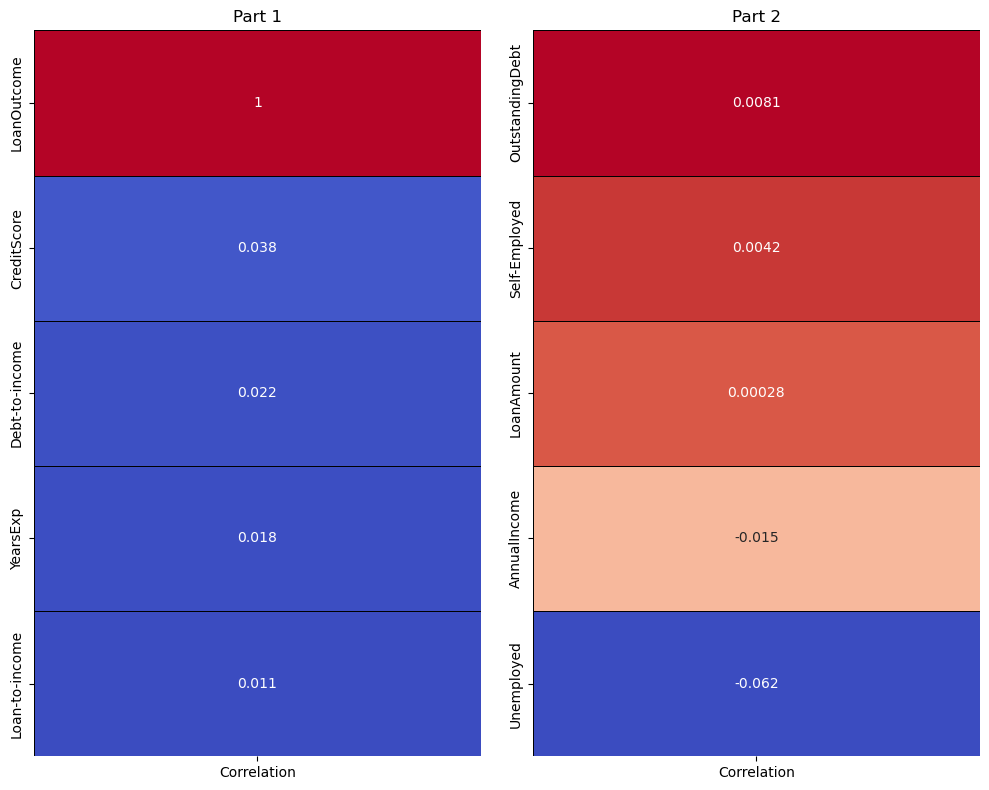

In [64]:
corr = df1.corrwith(df1['LoanOutcome']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlation']

colors = 'coolwarm'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

plt.subplot(1, 2, 1)
sns.heatmap(corr.iloc[:5, :], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
plt.title('Part 1')

plt.subplot(1, 2, 2)
sns.heatmap(corr.iloc[5:10, :], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
plt.title('Part 2')

fig.tight_layout(w_pad=2)
plt.show()

# Outlier Handling

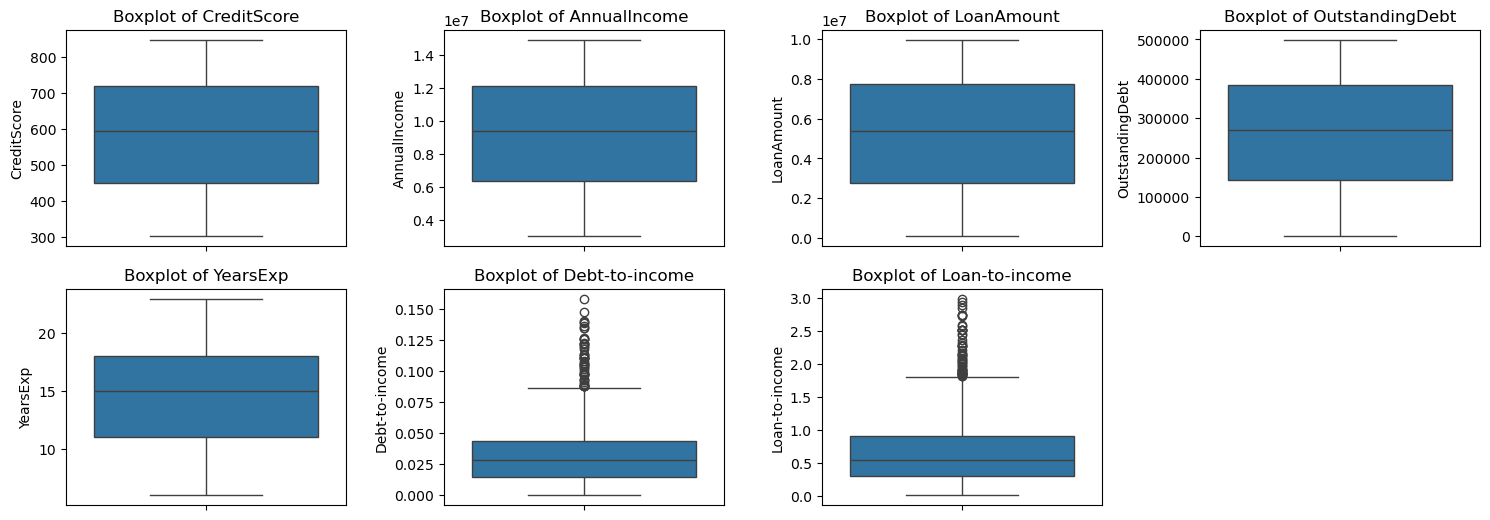

In [74]:
fig, axes = plt.subplots(3, 4, figsize=(15, 8))  # 3 rows, 4 columns

features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'OutstandingDebt', 'YearsExp', 'Debt-to-income','Loan-to-income']

axes = axes.flatten()  # Make it a 1D list for easy indexing

for i, feature in enumerate(features):
    sns.boxplot(y=df1[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

# Hide any extra subplots if not used
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Flooring & Capping Technique

In [88]:
df2 = df1.iloc[:,:]

def outliers_for_features(df, col):
    Q1 = df.loc[:,col].quantile(0.25)
    Q3 = df.loc[:,col].quantile(0.75)

    upper_limit = Q3 + 1.5*(Q3-Q1)
    lower_limit = Q1 - 1.5*(Q3-Q1)

    return df2[col].apply(lambda x : upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)

for col in ['Debt-to-income','Loan-to-income']:
    df2[col] = outliers_for_features(df, col)

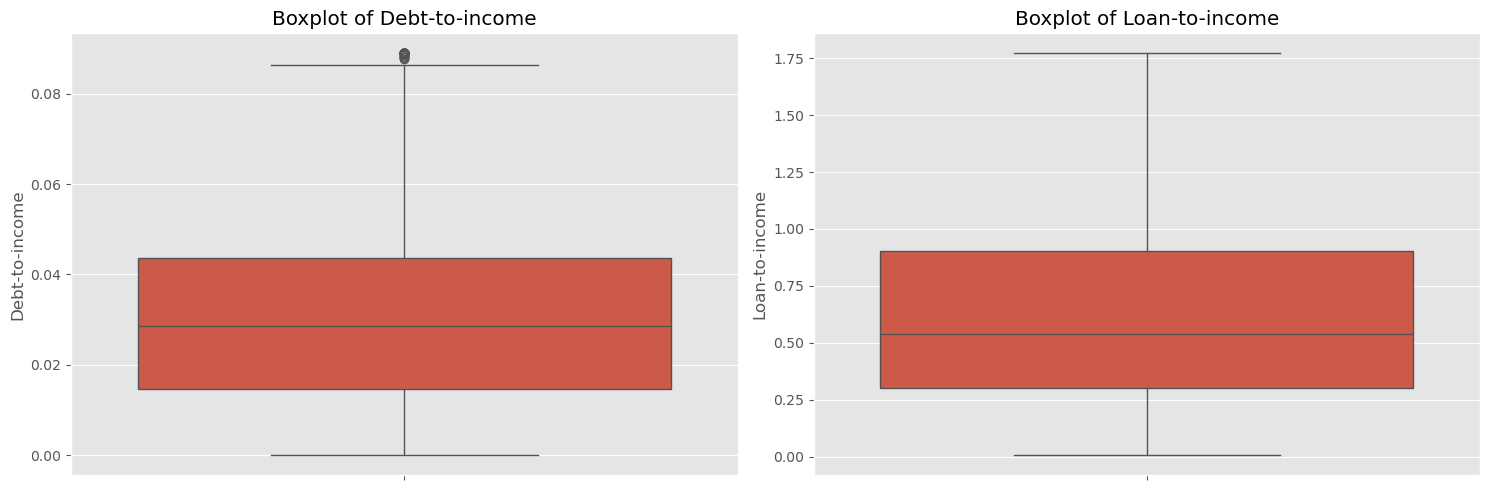

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row,  columns

features = ['Debt-to-income','Loan-to-income']

for i, feature in enumerate(features):
    sns.boxplot(y=df2[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

# Clustering Analysis

In [77]:
# For Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# For Hopkins Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# For K Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For Hierarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

plt.style.use("ggplot")

# Checking Suitability of dataset for clustering, Hopkins test

In [80]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [82]:
hopkins(df1)

0.6983997904348381

In [92]:
# df2 after applying flooring & capping
hopkins(df2)

0.6582663280651462

### The hopkins test shows that there's no need for the flooring and capping technique on the data, as the original data is well within range and there are no unnecessary outliers. so we use the data without the flooring and capping technique (df1).

# Clustering

In [97]:
## Scaling the Data
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df1.iloc[:, 1:])

# Kmeans

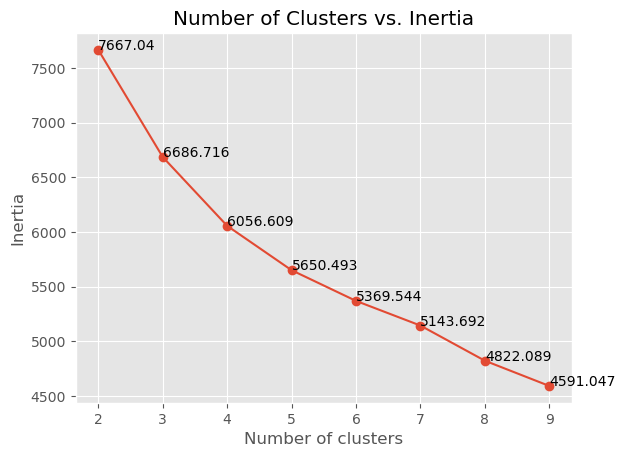

In [101]:
#Choosing k-value for K means algorithm
ssd = []
num_of_clusters = list(range(2,10))

for n in num_of_clusters:
    km = KMeans(n_clusters = n, max_iter = 50, random_state=101).fit(df_scaled)
    ssd.append(km.inertia_)

plt.plot(num_of_clusters, ssd, marker='o')

for xy in zip(num_of_clusters, ssd):
    plt.annotate(text = round(xy[1],3), xy = xy,  textcoords='data')

plt.xlabel("Number of clusters")
plt.ylabel("Inertia") # Inertia is within cluster sum of squares
plt.title("Number of Clusters vs. Inertia")
plt.show()

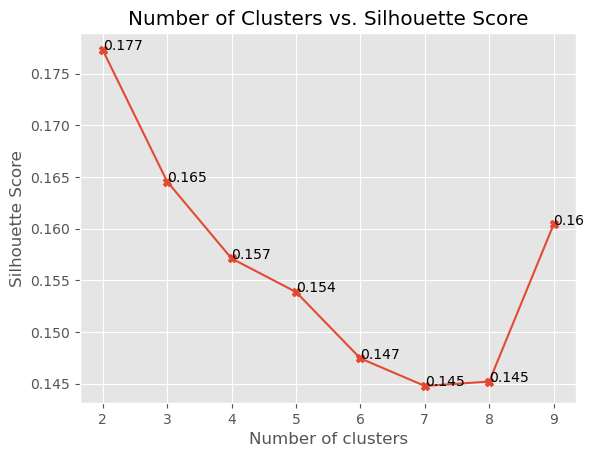

In [103]:
silhouette_value = []
for n in range(2,10):
    km = KMeans(n_clusters = n, random_state=101).fit(df_scaled)
    silhouette_value.append(silhouette_score(df_scaled, km.labels_))

plt.plot(num_of_clusters, silhouette_value, marker='X', label=silhouette_value)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Number of Clusters vs. Silhouette Score")

for xy in zip(num_of_clusters, silhouette_value):
    plt.annotate(text = round(xy[1],3), xy = xy,  textcoords='data')

plt.show()

In [105]:
# Building K Means model with 6 clusters
km_cluster = KMeans(n_clusters=6, max_iter=100 , random_state = 101)
km_cluster.fit(df_scaled)

KMeans(max_iter=100, n_clusters=6, random_state=101)

In [109]:
print(km_cluster.labels_)
print(km_cluster.labels_.shape)

[0 3 3 ... 3 3 1]
(1020,)


# Hierarchical

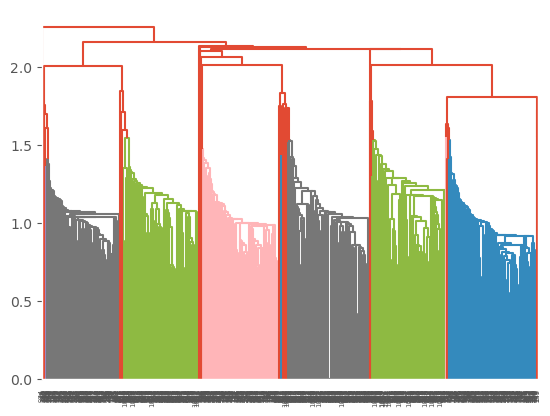

In [112]:
mergings_single = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()

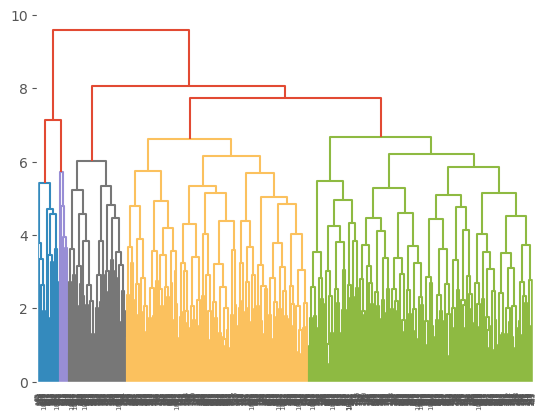

In [114]:
mergings_complete = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

### We will be using the clusters from the kmeans, the Hierarchical clusters were done to validate the 6 clusters seen in Kmeans.

In [125]:
df1.head()

,CreditScore,AnnualIncome,LoanAmount,OutstandingDebt,LoanOutcome,YearsExp,Debt-to-income,Loan-to-income,Self-Employed,Unemployed
0,655,6306291,417034,159749,0,10,0.025332,0.066130,0,0
3,759,7697704,9468833,3438,0,12,0.000447,1.230085,0,1
5,708,7135340,2794275,43990,0,12,0.006165,0.391611,0,1
6,334,11476173,6295274,250980,0,17,0.021870,0.548552,1,0
7,807,12481551,9898409,277781,0,15,0.022255,0.793043,0,0


In [127]:
df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome,Appdate,Apptime,Empdate,Emptime,months_count,YearsExp,Debt-to-income,Loan-to-income
0,2021-01-01 00:00:00.000000000,655,6306291,417034,Employed,159749,2011-11-24 19:42:42.126610048,Denied,2021-01-01,00:00:00,2011-11-24,19:42:42.126610,110,10,0.025332,0.066130
1,2021-01-02 02:16:56.216216216,652,7555169,5730135,Self-Employed,334035,2006-12-25 19:23:45.596053728,Approved,2021-01-02,02:16:56.216216,2006-12-25,19:23:45.596053,169,15,0.044213,0.758439
2,2021-01-03 04:33:52.432432432,490,9578220,1886511,Unemployed,159927,2006-05-06 00:34:43.639353248,Approved,2021-01-03,04:33:52.432432,2006-05-06,00:34:43.639353,176,15,0.016697,0.196958
3,2021-01-04 06:50:48.648648648,759,7697704,9468833,Unemployed,3438,2009-01-22 19:20:12.496574400,Denied,2021-01-04,06:50:48.648648,2009-01-22,19:20:12.496574,144,12,0.000447,1.230085
4,2021-01-05 09:07:44.864864864,800,9040140,655286,Self-Employed,110166,2005-10-19 11:13:37.867909024,Approved,2021-01-05,09:07:44.864864,2005-10-19,11:13:37.867909,183,16,0.012186,0.072486


In [131]:
df_clust = df1.reset_index(drop=True)
df_clust = pd.concat([df_clust, pd.DataFrame(km_cluster.labels_, columns=['cluster_id_km'])], axis=1)
df_clust.head()

,CreditScore,AnnualIncome,LoanAmount,OutstandingDebt,LoanOutcome,YearsExp,Debt-to-income,Loan-to-income,Self-Employed,Unemployed,cluster_id_km
0,655,6306291,417034,159749,0,10,0.025332,0.066130,0,0,0
1,759,7697704,9468833,3438,0,12,0.000447,1.230085,0,1,3
2,708,7135340,2794275,43990,0,12,0.006165,0.391611,0,1,3
3,334,11476173,6295274,250980,0,17,0.021870,0.548552,1,0,2
4,807,12481551,9898409,277781,0,15,0.022255,0.793043,0,0,5


In [133]:
df_clust.shape

(1020, 11)

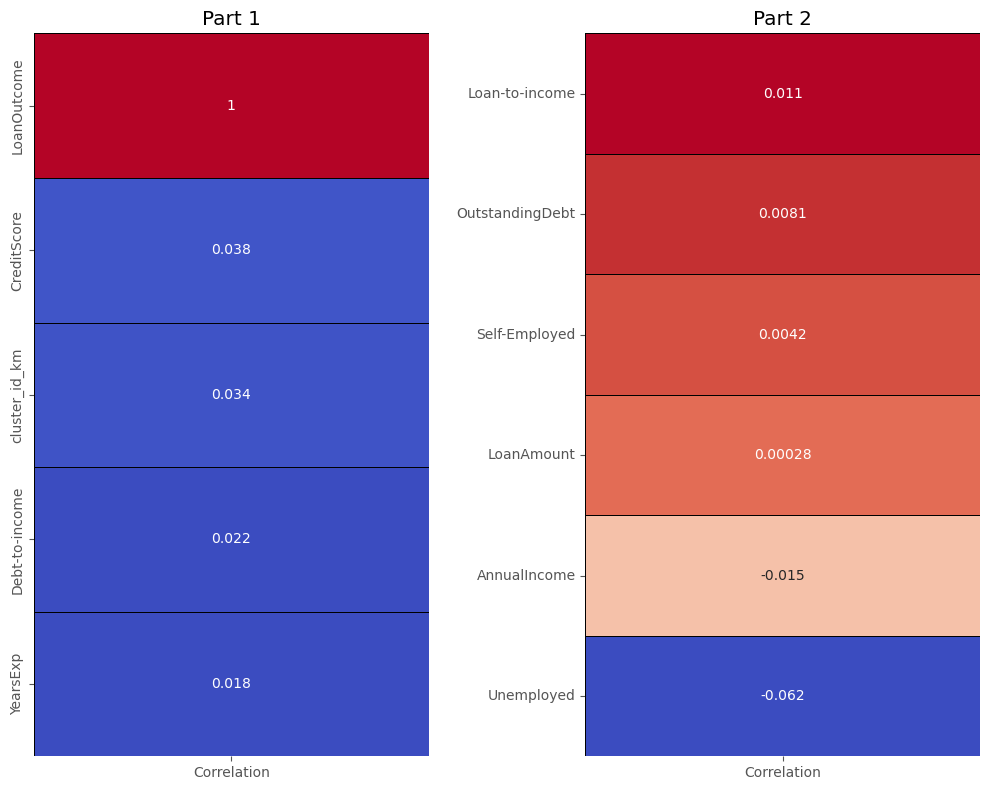

In [135]:
corr = df_clust.corrwith(df_clust['LoanOutcome']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlation']

colors = 'coolwarm'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

plt.subplot(1, 2, 1)
sns.heatmap(corr.iloc[:5, :], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
plt.title('Part 1')

plt.subplot(1, 2, 2)
sns.heatmap(corr.iloc[5:11, :], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
plt.title('Part 2')

fig.tight_layout(w_pad=2)
plt.show()

# Classification

In [138]:
x = df_clust.drop('LoanOutcome', axis = 1)
y = df_clust['LoanOutcome']

In [140]:
scalar = StandardScaler()

In [142]:
x = scalar.fit_transform(x)

In [144]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [146]:
# fitting our K-nearest neighbour algorithm
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [148]:
# predicting the test set
y_pred2 = knn.predict(x_test)

In [150]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        95
           1       0.61      0.68      0.64       109

    accuracy                           0.60       204
   macro avg       0.59      0.59      0.59       204
weighted avg       0.60      0.60      0.59       204



In [152]:
print(accuracy_score(y_test,y_pred2))

0.5980392156862745


In [154]:
print(precision_score(y_test,y_pred2))

0.6115702479338843


In [156]:
print(recall_score(y_test,y_pred2))

0.6788990825688074


# Cross-Validation Score

In [158]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, x, y, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {scores.mean():.4f}")

Mean Accuracy: 0.5647


# AUC Score

In [160]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)

# Use scoring='roc_auc' for AUC
auc_scores = cross_val_score(knn, x, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.5842


# Random Forest

In [165]:
# fitting the Random forest classifier
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [167]:
# predicting the test set
y_pred4 = rfc.predict(x_test)

In [169]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        95
           1       0.70      0.60      0.64       109

    accuracy                           0.65       204
   macro avg       0.65      0.65      0.65       204
weighted avg       0.65      0.65      0.65       204



In [171]:
print(accuracy_score(y_test,y_pred4))

0.6470588235294118


In [173]:
print(precision_score(y_test,y_pred4))

0.6989247311827957


In [175]:
print(recall_score(y_test,y_pred4))

0.5963302752293578


# Cross-Validation

In [177]:
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rfc, x, y, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {scores.mean():.4f}")

Mean Accuracy: 0.6980


# AUC Score

In [179]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Use scoring='roc_auc' for AUC
auc_scores = cross_val_score(rfc, x, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.7846
